In [1]:
import numpy as np
from keras.utils import np_utils
import keras.preprocessing.sequence as sq

Using TensorFlow backend.


In [2]:
npzdata=np.load("data.npz")

In [3]:
data=npzdata['data']
labels=npzdata['labels']

In [4]:
maxlen=150
data=sq.pad_sequences(data,maxlen=maxlen,padding='post',truncating='post',dtype='float64')
data=data.reshape(data.shape[0],data.shape[1],1)
dict_label={}
n=0
set_labels=list(set(labels))
for l in set_labels:
    dict_label[l]=n
    n+=1

In [5]:
labels_new=[]
for l in labels:
    labels_new.append(dict_label[l])
label_1=np_utils.to_categorical(labels_new)

In [6]:
def generateData(data,labels,batch_size=32):
    nb_instances = data.shape[0]
    nb_classes = labels.shape[1]
    sample_shape = data[0].shape
    batch_data_shape = tuple([batch_size] + list(sample_shape))
    batch_label_shape = (batch_size, nb_classes)
    print(batch_data_shape)
    print(batch_label_shape)
    # Infinite loop
    while True:
        # Generate an exploration order
        indices = np.arange(nb_instances)
        np.random.shuffle(indices)

        # Generate batches
        imax = int(len(indices) / batch_size)
        for i in range(imax):
            # Form a batch
            x = np.empty(batch_data_shape)
            y = np.empty(batch_label_shape)
            for j, k in enumerate(indices[i * batch_size: (i + 1) * batch_size]):
                x[j] = data[k]
                y[j] = labels[k]
            if x.shape != batch_data_shape:
                print(x.shape)
                exit(0)
            yield x, y

In [7]:
from sklearn import model_selection
X_train, x_test, Y_train, y_test = model_selection.train_test_split(data, label_1, test_size=0.15)
x_train, x_val, y_train, y_val = model_selection.train_test_split(X_train, Y_train, test_size=0.18)

trainGen=generateData(x_train,y_train)
valGen=generateData(x_val,y_val)
testGen=generateData(x_test,y_test)

In [8]:
from keras.layers.core import Dense, Dropout,Permute,Lambda,RepeatVector,Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Input,multiply
from keras.models import *
from keras.optimizers import RMSprop
import keras.backend as K

In [9]:
input_length=maxlen
input_dim=1

In [10]:
inputs = Input(shape=(input_length, input_dim))

In [11]:
lstm_activitions=LSTM(units=128,activation='tanh',recurrent_activation='hard_sigmoid',return_sequences=True,dropout=0.2)(inputs)

In [12]:
attention= Permute((2, 1))(lstm_activitions)

In [13]:
attention = Dense(input_length, activation='softmax')(attention)

In [14]:
attention = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(attention)
attention = RepeatVector(input_dim)(attention)

In [15]:
a_probs = Permute((2, 1), name='attention_vec')(attention)


In [16]:
output_attention_mul  = multiply([lstm_activitions, a_probs])

In [17]:
nb_classes=label_1.shape[1]

In [18]:
nb_classes

101

In [19]:
attention_mul = LSTM(units=128,activation='tanh',recurrent_activation='hard_sigmoid',return_sequences=False,dropout=0.2)(output_attention_mul)

In [20]:
y=Dense(nb_classes,activation='softmax',name='output')(attention_mul)

In [21]:
model=Model(inputs=[inputs],outputs=[y])

In [22]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 1)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 150, 128)     66560       input_1[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 128, 150)     0           lstm_1[0][0]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128, 150)     22650       permute_1[0][0]                  
__________________________________________________________________________________________________
dim_reduct

In [23]:
metrics=['accuracy']

In [24]:
optimizer=RMSprop(lr=0.001,decay=0.0)

In [25]:
model.compile(loss="categorical_crossentropy",optimizer=optimizer,metrics=metrics)

In [26]:
print (model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 1)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 150, 128)     66560       input_1[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 128, 150)     0           lstm_1[0][0]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128, 150)     22650       permute_1[0][0]                  
__________________________________________________________________________________________________
dim_reduct

In [27]:
history=model.fit_generator(generator=trainGen,steps_per_epoch=x_train.shape[0]//32,validation_data=valGen,validation_steps=x_val.shape[0]//32,epochs=5)

(32, 150, 1)Epoch 1/5

(32, 101)
5444/5445 [============================>.] - ETA: 0s - loss: 2.8514 - acc: 0.3066(32, 150, 1)
(32, 101)
5445/5445 [==============================] - 2288s 420ms/step - loss: 2.8513 - acc: 0.3066 - val_loss: 1.5142 - val_acc: 0.5939
Epoch 2/5
5445/5445 [==============================] - 2292s 421ms/step - loss: 1.4768 - acc: 0.6112 - val_loss: 1.3840 - val_acc: 0.6175
Epoch 3/5
5445/5445 [==============================] - 2308s 424ms/step - loss: 0.9812 - acc: 0.7351 - val_loss: 0.7831 - val_acc: 0.7802
Epoch 4/5
5445/5445 [==============================] - 2317s 425ms/step - loss: 0.7740 - acc: 0.7885 - val_loss: 0.6932 - val_acc: 0.8079
Epoch 5/5
5445/5445 [==============================] - 2359s 433ms/step - loss: 0.6661 - acc: 0.8164 - val_loss: 0.5977 - val_acc: 0.8352


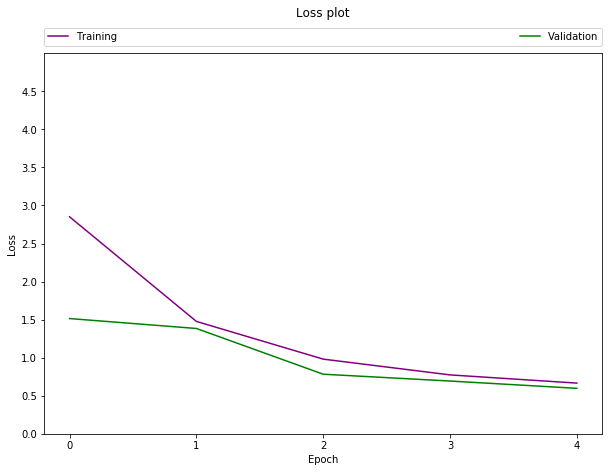

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label="Training", color='purple')
if history.history['val_loss'] is not None:
    plt.ylim(0, 5)
    plt.plot(history.history['val_loss'], label="Validation", color='green')
plt.title("Loss plot", y=1.08)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode='expand', borderaxespad=0.)
plt.yticks(np.arange(0, 5, 0.5))
plt.xticks(np.arange(0, 5, 1))
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

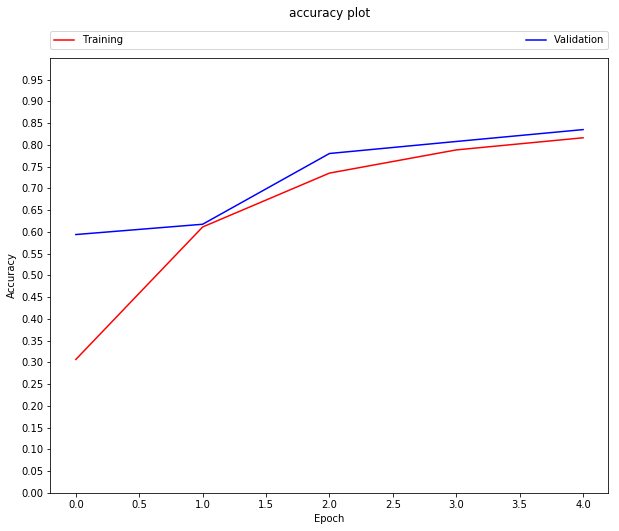

In [29]:

plt.figure(figsize=(10, 8))
plt.ylim(0, 1)
plt.plot(history.history['acc'], label="Training", color='red')
if history.history['val_acc'] is not None:
    plt.plot(history.history['val_acc'], label="Validation", color='blue')
plt.title("accuracy plot", y=1.08)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode='expand', borderaxespad=0.)
plt.yticks(np.arange(0, 1, 0.05))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [30]:
steps = x_test.shape[0]//32
scores = model.evaluate_generator(testGen, steps)
predicted = model.predict_generator(testGen, steps)

(32, 150, 1)
(32, 101)


In [31]:
test_loss = round(scores[0], 4)
test_acc = round(scores[1], 4)

In [32]:
test_loss

0.6092

In [33]:

test_acc

0.8293